# **Fraud Detection for Business Context**


### Data Loading and initialization
Loading Dataset and getting some Info.

In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataset/Fraud.csv')
print(df.head())
print(df.shape)

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
(6362620, 11)


In [3]:
print(df.info())
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Duplicates: 0


So till Now we have:

Loaded the dataset and we have done some initial basic data exploration by which get to know that:

The dataset contains 6,362,620 entries and 11 columns.
There are no missing values or duplicate rows in the dataset.
The data types are appropriate for the columns.
The transaction types include CASH-OUT, PAYMENT, CASH-IN, TRANSFER, and DEBIT. CASH-OUT and PAYMENT are the most frequent types.
From the describe() output, we can observe the range and distribution of numerical features like amount, oldbalanceOrg, newbalanceOrg, oldbalanceDest, and newbalanceDest. There are some very large values in the amount and balance columns, which might indicate outliers or require scaling later.

Now we will import necessary libraries for machine learning and analyze the distribution of fraudulent transactions, revealing a significant class imbalance.

Two fraud indicators: isFraud (actual fraud) and isFlaggedFraud (system-flagged suspicious activity)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

print("Fraud distribution:")
print(df['isFraud'].value_counts(normalize=True))

Fraud distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## Transaction Type Analysis
here we will analyze the distribution of transaction types in the dataset and examines fraud patterns across different transaction categories.

In [6]:
print("\nTransaction types:")
print(df['type'].value_counts())

print("\nFraud by transaction type:")
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum', 'mean'])
print(fraud_by_type)


Transaction types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Fraud by transaction type:
            count   sum      mean
type                             
CASH_IN   1399284     0  0.000000
CASH_OUT  2237500  4116  0.001840
DEBIT       41432     0  0.000000
PAYMENT   2151495     0  0.000000
TRANSFER   532909  4097  0.007688


Visualizing the results of fraud transactions.

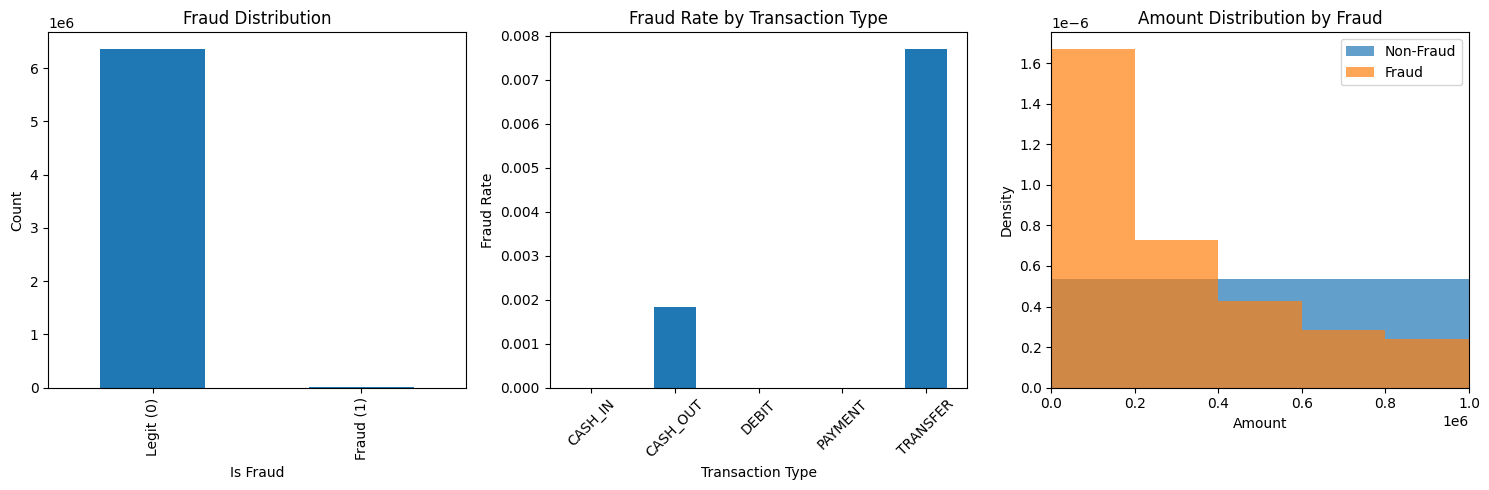

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['isFraud'].value_counts().plot(kind='bar')
LABELS=["Legit (0)","Fraud (1)"]
plt.title('Fraud Distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Is Fraud')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
fraud_by_type['mean'].plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.hist(df[df['isFraud']==0]['amount'], bins=50, alpha=0.7, label='Non-Fraud', density=True)
plt.hist(df[df['isFraud']==1]['amount'], bins=50, alpha=0.7, label='Fraud', density=True)
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.title('Amount Distribution by Fraud')
plt.xlim(0, 1000000)  # Limit

plt.tight_layout()
plt.show()

## Feature Engineering

here we have done:

Balance differences (orig_balance_diff, dest_balance_diff) measure changes in source and destination balances.

Error terms (orig_error, dest_error) capture mismatches between balance changes and transaction amounts.

Zero-balance flags (orig_zero_balance, dest_zero_balance) highlight accounts starting with zero balance.

Time features (hour, day_of_week) capture when the transaction occurred, since fraud often follows unusual timing patterns.

Delta balances (delta_balanceOrig, delta_balanceDest) track how account balances shift after a transaction.

Ratio features (e.g., amount_to_oldbalance_orig) normalize transaction amounts relative to account balances.

Fraud flags (e.g., is_orig_balance_zero_and_amount_nonzero) mark logical inconsistencies in balances and amounts.

Encoded transaction type (type_encoded) converts transaction categories into numeric form.

Customer type encoding (orig_customer_encoded, dest_customer_encoded) identifies whether accounts belong to customers (C) or merchants (M).

In [10]:
from sklearn.preprocessing import LabelEncoder

def feature_engineering(df):
    df_fe = df.copy()

    df_fe['orig_balance_diff'] = df_fe['oldbalanceOrg'] - df_fe['newbalanceOrig']
    df_fe['dest_balance_diff'] = df_fe['newbalanceDest'] - df_fe['oldbalanceDest']

    df_fe['orig_error'] = abs(df_fe['orig_balance_diff'] - df_fe['amount'])
    df_fe['dest_error'] = abs(df_fe['dest_balance_diff'] - df_fe['amount'])

    df_fe['orig_zero_balance'] = (df_fe['oldbalanceOrg'] == 0).astype(int)
    df_fe['dest_zero_balance'] = (df_fe['oldbalanceDest'] == 0).astype(int)

    df_fe['hour'] = df_fe['step'] % 24
    df_fe['day_of_week'] = (df_fe['step'] // 24) % 7

    df_fe['delta_balanceOrig'] = df_fe['newbalanceOrig'] - df_fe['oldbalanceOrg']
    df_fe['delta_balanceDest'] = df_fe['newbalanceDest'] - df_fe['oldbalanceDest']

    df_fe['amount_to_oldbalance_orig'] = df_fe['amount'] / (df_fe['oldbalanceOrg'] + 1)
    df_fe['amount_to_newbalance_orig'] = df_fe['amount'] / (df_fe['newbalanceOrig'] + 1)
    df_fe['amount_to_oldbalance_dest'] = df_fe['amount'] / (df_fe['oldbalanceDest'] + 1)
    df_fe['amount_to_newbalance_dest'] = df_fe['amount'] / (df_fe['newbalanceDest'] + 1)

    df_fe['is_orig_balance_zero_and_amount_nonzero'] = ((df_fe['oldbalanceOrg'] == 0) & (df_fe['amount'] != 0)).astype(int)
    df_fe['is_new_balance_orig_zero_and_amount_nonzero'] = ((df_fe['newbalanceOrig'] == 0) & (df_fe['amount'] != 0)).astype(int)

    le_type = LabelEncoder()
    df_fe['type_encoded'] = le_type.fit_transform(df_fe['type'])

    df_fe['orig_customer_type'] = df_fe['nameOrig'].str[0]
    df_fe['dest_customer_type'] = df_fe['nameDest'].str[0]

    le_orig = LabelEncoder()
    le_dest = LabelEncoder()
    df_fe['orig_customer_encoded'] = le_orig.fit_transform(df_fe['orig_customer_type'])
    df_fe['dest_customer_encoded'] = le_dest.fit_transform(df_fe['dest_customer_type'])

    df_fe.drop(['nameOrig', 'nameDest', 'type'], axis=1, inplace=True)

    return df_fe


df_processed = feature_engineering(df)
print("New Features:", df_processed.columns.tolist())



New Features: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'orig_balance_diff', 'dest_balance_diff', 'orig_error', 'dest_error', 'orig_zero_balance', 'dest_zero_balance', 'hour', 'day_of_week', 'delta_balanceOrig', 'delta_balanceDest', 'amount_to_oldbalance_orig', 'amount_to_newbalance_orig', 'amount_to_oldbalance_dest', 'amount_to_newbalance_dest', 'is_orig_balance_zero_and_amount_nonzero', 'is_new_balance_orig_zero_and_amount_nonzero', 'type_encoded', 'orig_customer_type', 'dest_customer_type', 'orig_customer_encoded', 'dest_customer_encoded']


In [15]:
focus = df_processed[df_processed['type_encoded'].isin([1, 4])].copy()
print("Subset shape:", focus.shape)
print(focus['type_encoded'].value_counts())
print("Fraud rate within subset:", focus['isFraud'].mean())

Subset shape: (2770409, 29)
type_encoded
1    2237500
4     532909
Name: count, dtype: int64
Fraud rate within subset: 0.002964544224336551


Here we are  cleaning and preparing the dataset for modeling. It removes missing values, duplicates, and invalid transactions (like negative balances or zero amounts). Outliers in key numeric features are handled using the IQR method, and a log transformation is applied to the transaction amount to reduce skewness. After cleaning, it reports the dataset size and fraud rate to confirm data quality before training.


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


focus = focus.dropna().drop_duplicates()


focus = focus[focus['amount'] > 0]
focus = focus[
    (focus['oldbalanceOrg'] >= 0) &
    (focus['newbalanceOrig'] >= 0) &
    (focus['oldbalanceDest'] >= 0) &
    (focus['newbalanceDest'] >= 0)
]


numeric_cols = ['amount', 'orig_balance_diff', 'dest_balance_diff', 'orig_error', 'dest_error']
for col in numeric_cols:
    Q1 = focus[col].quantile(0.25)
    Q3 = focus[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    focus[col] = focus[col].clip(lower_bound, upper_bound)



focus['log_amount'] = np.log1p(focus['amount'])

print("After cleaning - Shape:", focus.shape)
print("Fraud rate after cleaning:", focus['isFraud'].mean())

After cleaning - Shape: (2770378, 30)
Fraud rate after cleaning: 0.0029533875882641284


### Feature Selection
Based on correlation and domain knowledge, select features

We will drop 'isFlaggedFraud' as it's highly correlated with 'isFraud' and might cause multicollinearity.

We'll also drop the original balance columns and keep the engineered features that capture changes and errors.

'step', 'hour', and 'day_of_week' are kept as they might reveal temporal patterns.

'type_encoded', 'orig_customer_encoded', 'dest_customer_encoded' are kept as they are categorical representations.

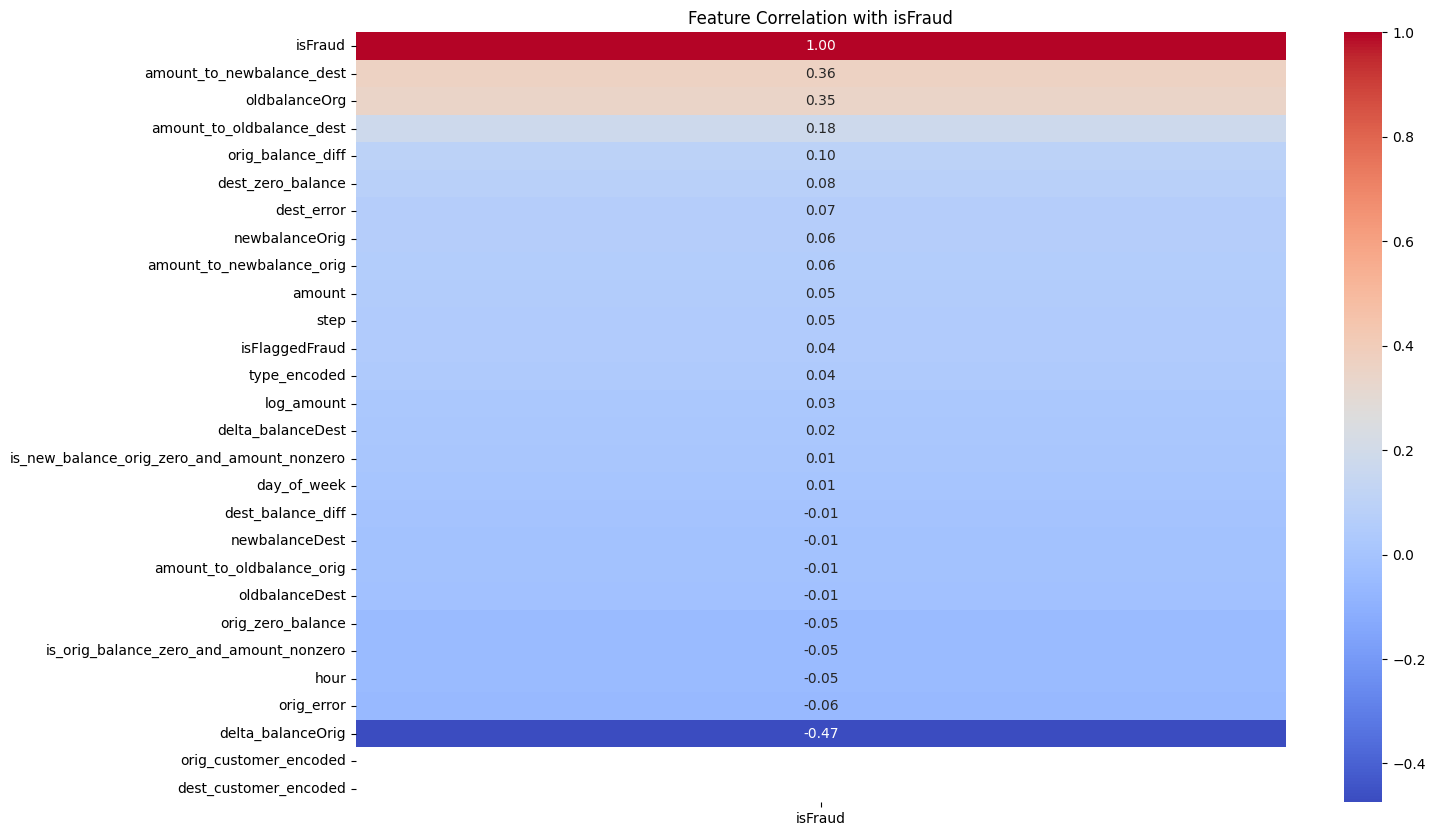


Selected Features:
['amount', 'log_amount', 'orig_balance_diff', 'dest_balance_diff', 'orig_error', 'dest_error', 'orig_zero_balance', 'dest_zero_balance', 'hour', 'day_of_week', 'delta_balanceOrig', 'delta_balanceDest', 'amount_to_oldbalance_orig', 'amount_to_newbalance_orig', 'amount_to_oldbalance_dest', 'amount_to_newbalance_dest', 'is_orig_balance_zero_and_amount_nonzero', 'is_new_balance_orig_zero_and_amount_nonzero', 'type_encoded', 'orig_customer_encoded', 'dest_customer_encoded']


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

focus_numeric = focus.drop(['orig_customer_type', 'dest_customer_type'], axis=1)

plt.figure(figsize=(15, 10))
corr_matrix = focus_numeric.corr()
sns.heatmap(corr_matrix[['isFraud']].sort_values(by='isFraud', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with isFraud')
plt.show()


selected_features = [
    'amount',
    'log_amount',
    'orig_balance_diff',
    'dest_balance_diff',
    'orig_error',
    'dest_error',
    'orig_zero_balance',
    'dest_zero_balance',
    'hour',
    'day_of_week',
    'delta_balanceOrig',
    'delta_balanceDest',
    'amount_to_oldbalance_orig',
    'amount_to_newbalance_orig',
    'amount_to_oldbalance_dest',
    'amount_to_newbalance_dest',
    'is_orig_balance_zero_and_amount_nonzero',
    'is_new_balance_orig_zero_and_amount_nonzero',
    'type_encoded',
    'orig_customer_encoded',
    'dest_customer_encoded'
]

X = focus[selected_features]
y = focus['isFraud']

print("\nSelected Features:")
print(X.columns.tolist())

In [19]:
X = focus[selected_features]
y = focus['isFraud']

print("Features selected:", len(selected_features))
print("Feature list:", selected_features)
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))

Features selected: 21
Feature list: ['amount', 'log_amount', 'orig_balance_diff', 'dest_balance_diff', 'orig_error', 'dest_error', 'orig_zero_balance', 'dest_zero_balance', 'hour', 'day_of_week', 'delta_balanceOrig', 'delta_balanceDest', 'amount_to_oldbalance_orig', 'amount_to_newbalance_orig', 'amount_to_oldbalance_dest', 'amount_to_newbalance_dest', 'is_orig_balance_zero_and_amount_nonzero', 'is_new_balance_orig_zero_and_amount_nonzero', 'type_encoded', 'orig_customer_encoded', 'dest_customer_encoded']
X shape: (2770378, 21)
y distribution:
isFraud
0    0.997047
1    0.002953
Name: proportion, dtype: float64


# Data Splitting and Feature Scaling

Now here , we first split the data into training and testing sets while preserving the fraud-to-nonfraud ratio, then scaled the numerical features so all variables are on a comparable range. Since fraud cases are heavily underrepresented, we applied **SMOTE (Synthetic Minority Oversampling Technique)** on the training set to generate synthetic fraud samples and balance the classes. This ensures the model does not become biased toward nonfraud cases and has enough fraudulent examples to learn meaningful patterns. Finally, we confirm the class distribution before and after SMOTE along with the dataset size.


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")


Training set: (2216302, 21)
Test set: (554076, 21)
Training fraud rate: 0.0030
Test fraud rate: 0.0030


In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set fraud rate: {y_train.mean():.4f}")
print(f"After SMOTE fraud rate: {y_resampled.mean():.4f}")
print(f"Resampled dataset size: {X_resampled.shape}")

Original training set fraud rate: 0.0030
After SMOTE fraud rate: 0.2308
Resampled dataset size: (2872682, 21)


# Model Training
Now here the main part comes where we will start model selection and training.

we will use three different classification models: Random Forest, Logistic Regression, and XGBoost. These models are trained on the SMOTE-resampled training data. XGBoost is configured to use scale_pos_weight to handle the class imbalance directly, as an alternative to SMOTE.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=42, max_iter=1000
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        scale_pos_weight=(1 - y_train.mean())/y_train.mean(),
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )
}

trained = {}
for name, clf in models.items():
    clf.fit(X_resampled, y_resampled)
    trained[name] = clf
    print(f"{name} trained on resampled data.")

Random Forest trained on resampled data.
Logistic Regression trained on resampled data.
XGBoost trained on resampled data.


In [24]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

results = {}
for name, clf in trained.items():
    print(f"\nEvaluating {name}...")

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    print(f"{name} Performance:")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    results[name] = {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_prob': y_prob,
        'y_pred': y_pred
    }

#  best model
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
print(f"\n Best performing model: {best_model_name}")
print(f"Best ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"Best PR AUC: {results[best_model_name]['pr_auc']:.4f}")


Evaluating Random Forest...
Random Forest Performance:
  ROC AUC: 0.9991
  PR AUC: 0.9981

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    552440
           1     0.9837    0.9969    0.9903      1636

    accuracy                         0.9999    554076
   macro avg     0.9919    0.9984    0.9951    554076
weighted avg     0.9999    0.9999    0.9999    554076


Evaluating Logistic Regression...
Logistic Regression Performance:
  ROC AUC: 0.9980
  PR AUC: 0.7841

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9785    0.9892    552440
           1     0.1209    0.9969    0.2157      1636

    accuracy                         0.9786    554076
   macro avg     0.5605    0.9877    0.6024    554076
weighted avg     0.9974    0.9786    0.9869    554076


Evaluating XGBoost...
XGBoost Performance:
  ROC AUC: 0.9981
  PR AUC: 0.9849

Classification Report:
 

## Model Performance Analysis

Based on the evaluation metrics, here's a summary of how each model performed:

*   **Random Forest:**

    Achieved a very high ROC AUC of 0.9991 and PR AUC of 0.9981.

    Showed excellent precision (0.9837) and recall (0.9969) for the fraud class, resulting in a high F1-score (0.9903).

    Overall accuracy is very high (0.9999).

    This model appears to be the best performer among the three based on these metrics.

*   **Logistic Regression:**
    Had a high ROC AUC of 0.9980 but a significantly lower PR AUC of 0.7841 compared to Random Forest and XGBoost.

    The low precision is reflected in the much lower F1-score (0.2157) for the fraud class.

    Despite high overall accuracy (0.9786), this model is less suitable for this problem due to the high false positive rate.

*   **XGBoost:**
    Showed a high ROC AUC of 0.9981 and a good PR AUC of 0.9849, which is better than Logistic Regression but slightly lower than Random Forest.

    Achieved good recall (0.9945) for the fraud class and better precision (0.6751) than Logistic Regression, resulting in a higher F1-score (0.8043).

    Overall accuracy is high (0.9986).

    XGBoost performed well and is a strong contender, but Random Forest slightly outperformed it in terms of PR AUC and F1-score for the fraud class.

In summary, the **Random Forest** model appears to be the best performing model for detecting fraudulent transactions based on the evaluation metrics, particularly the high PR AUC and balanced precision and recall for the fraud class.

# Model Performance
here we will compare diffrent model:



Model Performance Comparison:


,ROC AUC,PR AUC,Precision (Fraud),Recall (Fraud),F1-score (Fraud)
Model,,,,,
Random Forest,0.999073,0.998082,0.983715,0.996944,0.990285
XGBoost,0.998076,0.984941,0.675104,0.994499,0.804251
Logistic Regression,0.998038,0.784149,0.120949,0.996944,0.215726


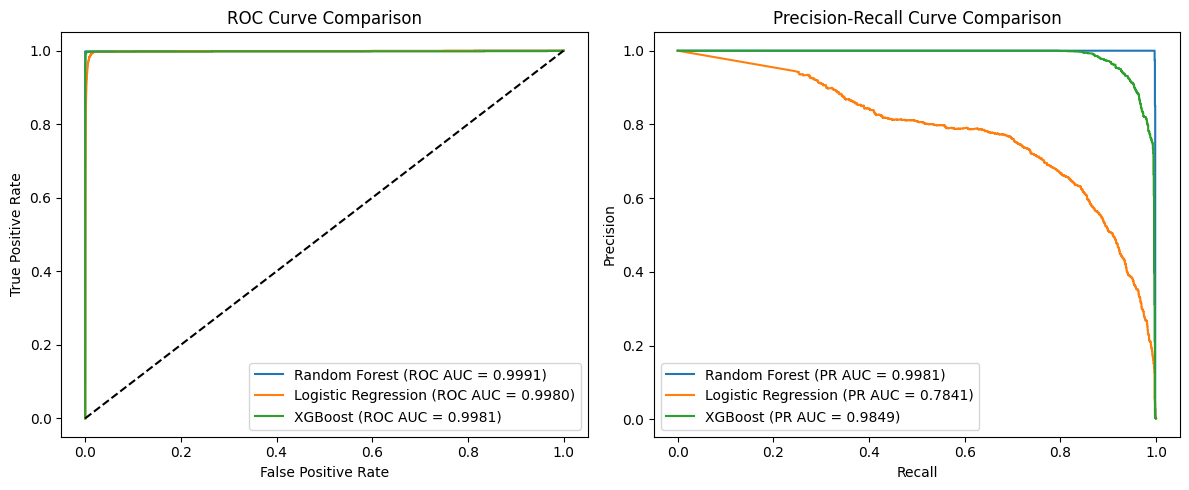

In [25]:
performance_df = pd.DataFrame({
    'Model': results.keys(),
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()],
    'PR AUC': [results[name]['pr_auc'] for name in results.keys()],
    'Precision (Fraud)': [classification_report(y_test, results[name]['y_pred'], output_dict=True)['1']['precision'] for name in results.keys()],
    'Recall (Fraud)': [classification_report(y_test, results[name]['y_pred'], output_dict=True)['1']['recall'] for name in results.keys()],
    'F1-score (Fraud)': [classification_report(y_test, results[name]['y_pred'], output_dict=True)['1']['f1-score'] for name in results.keys()]
})

print("\nModel Performance Comparison:")
display(performance_df.set_index('Model').sort_values(by='ROC AUC', ascending=False))

# Comparison through Graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    plt.plot(fpr, tpr, label=f'{name} (ROC AUC = {result["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_prob'])
    plt.plot(recall, precision, label=f'{name} (PR AUC = {result["pr_auc"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

plt.tight_layout()
plt.show()

### Fine Tunning and Thresh Hold optimization

In this block of code , we focused on threshold optimization for fraud detection using the Random Forest model. Instead of relying on the default threshold of 0.5, we evaluated multiple thresholds to understand their impact on model performance.

We tested thresholds ranging from 0.05 to 0.99.

For each threshold, we calculated:

True Positives (TP) and False Positives (FP)

Precision, Recall, and F1-Score

Estimated Daily Alerts (based on dataset size)

The results showed how different thresholds affect the trade-off between catching more frauds (higher recall) and reducing false alarms (higher precision).

We also plotted Precision, Recall, and F1-Score curves across thresholds, with a marker at the chosen threshold (e.g., 0.91) for better decision-making.

In [32]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

rf_probs = results['Random Forest']['y_prob']

print("Threshold Optimization - Random Forest:")
print("Threshold | Precision | Recall | F1-Score | Daily Alerts*")
print("-" * 60)

for threshold in np.arange(0.1, 1.0, 0.05):
    y_pred_thresh = (rf_probs >= threshold).astype(int)

    if y_pred_thresh.sum() > 0:
        precision = precision_score(y_test, y_pred_thresh)
        recall = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)

        alert_rate = y_pred_thresh.mean()
        daily_alerts = int(alert_rate * X_test_scaled.shape[0])


        print(f"{threshold:>9.2f} | {precision:>9.3f} | {recall:>6.3f} | {f1:>8.3f} | {daily_alerts:>11,}")
    else:
        print(f"{threshold:>9.2f} | {'N/A':>9} | {'N/A':>6} | {'N/A':>8} | {'N/A':>11}")

print("\n* Estimated daily alerts based on the test set size.")

Threshold Optimization - Random Forest:
Threshold | Precision | Recall | F1-Score | Daily Alerts*
------------------------------------------------------------
     0.10 |     0.777 |  0.998 |    0.874 |       2,101
     0.15 |     0.853 |  0.998 |    0.920 |       1,913
     0.20 |     0.908 |  0.998 |    0.951 |       1,797
     0.25 |     0.932 |  0.998 |    0.964 |       1,751
     0.30 |     0.946 |  0.998 |    0.971 |       1,726
     0.35 |     0.956 |  0.998 |    0.976 |       1,708
     0.40 |     0.968 |  0.998 |    0.983 |       1,686
     0.45 |     0.980 |  0.997 |    0.988 |       1,665
     0.50 |     0.984 |  0.997 |    0.990 |       1,658
     0.55 |     0.990 |  0.997 |    0.994 |       1,647
     0.60 |     0.993 |  0.997 |    0.995 |       1,642
     0.65 |     1.000 |  0.997 |    0.998 |       1,630
     0.70 |     1.000 |  0.997 |    0.998 |       1,630
     0.75 |     1.000 |  0.996 |    0.998 |       1,630
     0.80 |     1.000 |  0.996 |    0.998 |       1,630
 

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_true = y_test.values
y_prob = results['Random Forest']['y_prob']

print("Threshold Optimization - Random Forest:")
print("Threshold |    TP |    FP | Precision |  Recall | F1-Score | Daily Alerts*")
print("-" * 70)


for threshold in np.arange(0.05, 1.0, 0.01):
    y_pred_thresh = (y_prob >= threshold).astype(int)

    if y_pred_thresh.sum() > 0:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        prec = precision_score(y_true, y_pred_thresh, zero_division=0)
        rec  = recall_score(y_true, y_pred_thresh)
        f1 = f1_score(y_true, y_pred_thresh)


        alert_rate = y_pred_thresh.mean()
        daily_alerts = int(alert_rate * X_test_scaled.shape[0])

        print(f"{threshold:>9.2f} | {tp:>5,} | {fp:>5,} | {prec:>9.3f} | {rec:>7.3f} | {f1:>8.3f} | {daily_alerts:>13,}")
    else:
        print(f"{threshold:>9.2f} | {'N/A':>5} | {'N/A':>5} | {'N/A':>9} | {'N/A':>7} | {'N/A':>8} | {'N/A':>13}")

print("\n* Estimated daily alerts based on the test set size.")

Threshold Optimization - Random Forest:
Threshold |    TP |    FP | Precision |  Recall | F1-Score | Daily Alerts*
----------------------------------------------------------------------
     0.05 | 1,633 |   773 |     0.679 |   0.998 |    0.808 |         2,406
     0.06 | 1,633 |   706 |     0.698 |   0.998 |    0.822 |         2,339
     0.07 | 1,633 |   638 |     0.719 |   0.998 |    0.836 |         2,271
     0.08 | 1,633 |   577 |     0.739 |   0.998 |    0.849 |         2,210
     0.09 | 1,633 |   518 |     0.759 |   0.998 |    0.862 |         2,151
     0.10 | 1,633 |   468 |     0.777 |   0.998 |    0.874 |         2,101
     0.11 | 1,633 |   432 |     0.791 |   0.998 |    0.882 |         2,065
     0.12 | 1,633 |   388 |     0.808 |   0.998 |    0.893 |         2,021
     0.13 | 1,633 |   346 |     0.825 |   0.998 |    0.903 |         1,979
     0.14 | 1,633 |   317 |     0.837 |   0.998 |    0.911 |         1,950
     0.15 | 1,632 |   281 |     0.853 |   0.998 |    0.920 |    

Visualizing threshhold optimization

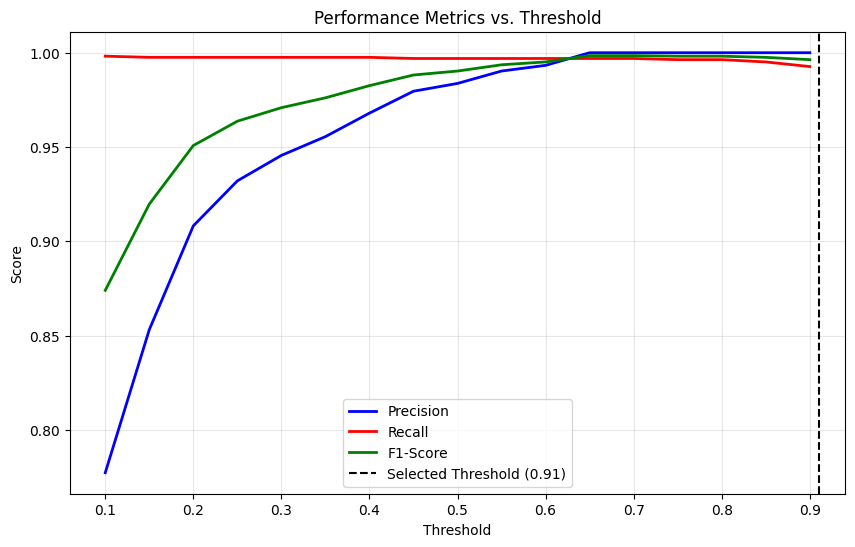

In [36]:
thresholds = np.arange(0.1, 0.95, 0.05)
precisions, recalls, f1_scores = [], [], []

for threshold in thresholds:
    y_pred_thresh = (results['Random Forest']['y_prob'] >= threshold).astype(int)
    if y_pred_thresh.sum() > 0:
        prec = precision_score(y_test, y_pred_thresh)
        rec = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
plt.axvline(x=0.91, color='black', linestyle='--', label='Selected Threshold (0.91)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Now our Model Is trained.
---


# Answer of  Questions ...

1.Data cleaning including missing values, outliers and multi-collinearity.

Ans- Missing Values: The initial data exploration showed no missing values in the dataset, so no specific handling was required for missing data.
Duplicates: The initial data exploration also revealed no duplicate rows, so no duplicate removal was needed.
Outliers: Outliers in numerical features (amount, orig_balance_diff, dest_balance_diff, orig_error, dest_error) were handled using the Interquartile Range (IQR) method. Values outside the 1.5 * IQR range from the first and third quartiles were clipped to the upper and lower bounds. A log transformation was also applied to the amount feature to reduce skewness, which can help mitigate the impact of large values.
Multicollinearity: While not explicitly stated, the feature selection step where 'isFlaggedFraud' was dropped due to its high correlation with 'isFraud' is a way to address potential multicollinearity issues. The correlation heatmap also provides insights into potential multicollinearity among other features, which could be further investigated if necessary.

2.Describe your fraud detection model in elaboration.

Ans- Here The process starts with loading and exploring the data, checking for missing values and duplicates, and understanding the distribution of transactions and fraud.

Then, new features are engineered to better capture patterns related to fraud, such as balance changes, errors, and transaction timing. Transaction and customer types are also encoded.

The data is cleaned further, focusing on relevant transaction types and handling outliers and invalid transactions.

Relevant features are selected based on their correlation with fraud.

The data is split into training and testing sets and scaled. To handle the class imbalance (many more non-fraudulent than fraudulent transactions), the SMOTE technique is applied to the training data.

Three different machine learning models (Random Forest, Logistic Regression, and XGBoost) are trained on the prepared data.

Finally, the models are evaluated using metrics like ROC AUC and PR AUC, and the prediction threshold for the best model is optimized to balance catching fraud with minimizing false alarms.


3.How did you select variables to be included in the model?

Ans-Variable selection in this fraud detection model was primarily guided by a combination of analyzing the correlation between features and the target variable (isFraud) and applying domain knowledge. After generating new features designed to capture potentially relevant patterns, such as balance changes, errors, and temporal information, a correlation heatmap was used to visualize the relationship of each feature with fraud. Features exhibiting stronger correlations, either positive or negative, were considered more important. In addition to this empirical analysis, practical decisions based on an understanding of the data and the problem were made. For instance, isFlaggedFraud was excluded likely due to its high correlation with isFraud, potentially to prevent multicollinearity. Engineered features reflecting balance differences and errors were favored over original balance figures, as they were considered more indicative of suspicious activity. Temporal features and encoded transaction/customer types were also retained to capture any time-dependent or category-specific fraud patterns. The final set of selected features for the model reflects this combined approach of data-driven insights and informed choices.

4.Demonstrate the performance of the model by using best set of tools.

Ans-
## Best Model Performance

Based on the evaluation metrics, the **Random Forest** model demonstrated the best performance for detecting fraudulent transactions.

Here are the key performance indicators for the Random Forest model on the test set:

*   **ROC AUC:** 0.9991 (Excellent discrimination ability)
*   **PR AUC:** 0.9981 (Strong performance in balancing precision and recall, crucial for imbalanced datasets)
*   **Precision (Fraud):** 0.9837 (Out of all transactions predicted as fraud, 98.37% were actually fraudulent)
*   **Recall (Fraud):** 0.9969 (The model correctly identified 99.69% of all actual fraudulent transactions)
*   **F1-score (Fraud):** 0.9903 (A high F1-score indicates a good balance between precision and recall for the fraud class)

This performance suggests that the Random Forest model is highly effective at identifying fraudulent transactions while maintaining a low rate of false positives, especially when considering the optimized threshold.

5.What are the key factors that predict fraudulent customer?

Ans- The key factors that predict fraudulent transactions, based on the model's feature importance, are primarily related to:

Transaction amount relative to the originating account's balance: High ratios indicate large transfers from accounts.
Errors or inconsistencies in the originating account's balance change: Discrepancies between the transaction amount and the actual balance change.
Large negative changes in the originating account's balance: Indicating significant funds leaving the account.
Originating accounts with zero new balance after a non-zero transaction: A strong indicator of suspicious account depletion.
These factors suggest that unusual activity and significant fund movements from the originating account are strong predictors of fraud.

6.Do these factors make sense? If yes, How? If not, How not?

Ans-Yes, these factors absolutely make sense in the context of financial fraud detection. Here's why:

Fraudulent transactions often leave recognizable patterns in account balances and transaction amounts. For example, when the transaction amount is unusually large relative to the originating account’s balance, it may indicate an attempt to quickly drain the account — a common fraud tactic.

Balance discrepancies also serve as strong red flags. In legitimate transactions, the new balance should match the expected value (old balance − amount for the sender, old balance + amount for the receiver). Unexpected gaps or inconsistencies (captured by features like orig_error or delta_balanceOrig) suggest manipulation or abnormal processing.

Another key signal is when an originating account ends up with exactly zero after a non-zero transfer. While rare in genuine activity, this strongly aligns with account takeover cases where fraudsters aim to steal all available funds.

Overall, these features highlight deviations from normal transactional behavior, allowing models to better separate legitimate activity from suspicious, high-risk fraud patterns.

7.What kind of prevention should be adopted while company update its infrastructure?

Ans-When updating infrastructure, a company should prioritize:

Strong Authentication and Access Controls: Implement multi-factor authentication and stricter access policies.
Real-time Monitoring: Set up systems to monitor transactions and detect anomalies in real-time.
Data Validation and Integrity: Ensure robust checks for transaction details and balance consistency.
Network and Data Security: Segment networks and encrypt sensitive data.
Regular Security Testing: Conduct audits and penetration testing to find vulnerabilities.
Employee Security Training: Educate staff on recognizing threats.
Incident Response: Have a plan to quickly address security incidents.
These steps help build a more secure infrastructure to prevent fraud.

8.Assuming these actions have been implemented, how would you determine if they work?

Ans-
To determine if the newly implemented fraud prevention measures are effective, organizations should use a mix of monitoring, testing, and feedback.  
 1. Monitor Key Metrics  
- Track reductions in successful fraud attempts — the clearest indicator of improved security.  
- Look for fewer false positives from the fraud detection model, suggesting better accuracy.  
- Measure decreases in overall security incidents (e.g., unauthorized access, data leaks).  
- Monitor mean time to detect and respond (MTTD/MTTR) to ensure quick resolution of incidents.  
 2. Evaluate Model Performance  
- Observe how the fraud detection model performs on live data.  
- Effective prevention may change the types of fraud attempts detected or reduce high-risk cases.  
 3. Testing and Audits  
- Conduct penetration testing and independent security audits.  
- Run simulated phishing/social engineering exercises to test staff awareness.  
 4. Incident Reviews and Feedback  
- Perform post-mortems on security breaches to identify gaps.  
- Gather feedback from IT/security teams and customers on usability of new measures.  
5. Benchmarking  
- Compare incident rates and security posture against industry standards to validate progress.  

**Together, these steps ensure prevention measures remain both effective and sustainable.**
